# The GARCH Option Pricing Model

## Library Import

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf 
from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, SkewStudent, Normal, ConstantMean
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Importing Data.

We are using AMD as it is currently volatile and makes for a good demo.

In [2]:
amd = yf.download("AMD", period="10y", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [3]:
amd_close = amd.Close
amd_close

Date
2014-09-18      3.880000
2014-09-19      3.810000
2014-09-22      3.760000
2014-09-23      3.690000
2014-09-24      3.700000
                 ...    
2024-09-11    149.860001
2024-09-12    150.770004
2024-09-13    152.309998
2024-09-16    152.080002
2024-09-17    150.820007
Name: Close, Length: 2516, dtype: float64

<Axes: xlabel='Date'>

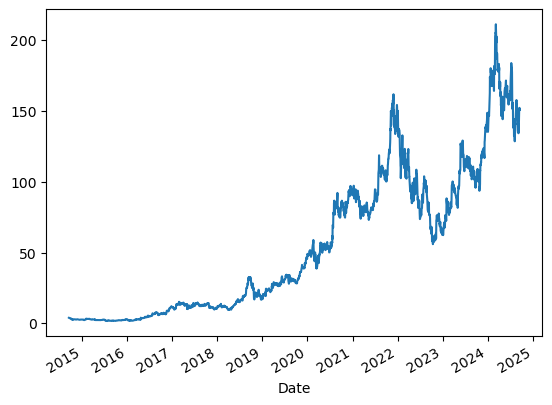

In [4]:
amd_close.plot.line()

## Calculating Log Return

The formula used is:  
$ log\;return = ln(\frac{X_t}{X_{t-1}})$  
This is mostly due to the fact that we want the process to be mean stationary and logging the prices do mostly that.  
Note that it can also be written as:  
$log\;return = ln(X_{t}) - ln(X_{t-1})$

In [5]:
amd_close_log_return = np.log(amd_close / amd_close.shift(1))

In [6]:
amd_close_log_return = amd_close_log_return.dropna()

<Axes: xlabel='Date'>

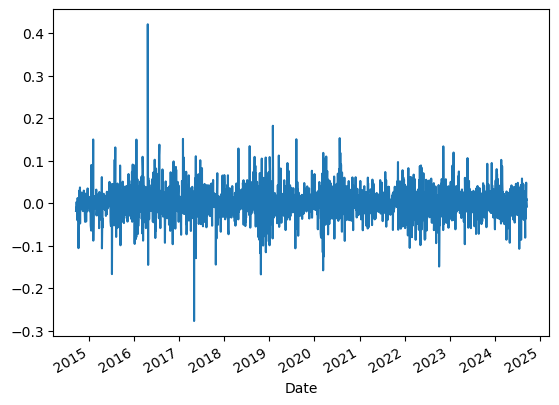

In [7]:
amd_close_log_return.plot.line()

## GARCH Model With Constant Mean and Normal Residuals

Now, we will fit a standard GARCH(1,1) Model (constant mean, normal residuals):    
mean model:  
$r_t = \mu + \epsilon_t$  
volatility model:  
$h_{t} = \sigma^{2}_{t} = \omega + \alpha\epsilon^{2}_{t-1} + \beta\sigma^{2}_{t-1}$  
$\epsilon_{t} = \sqrt{h_{t}}\epsilon_{t}, \; e_{t} \sim N(0,1)$  
Thus the model becomes:  
$r_t = \mu + \sqrt{h_{t}}\epsilon_{t}$  

Note: I tried some other garch like GJR but the shock parameter seems to be insignificant, oh well, besides the original paper uses vanilla GARCH(1,1) as well.

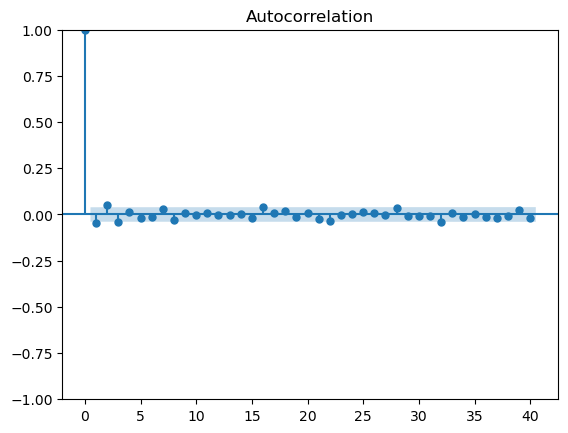

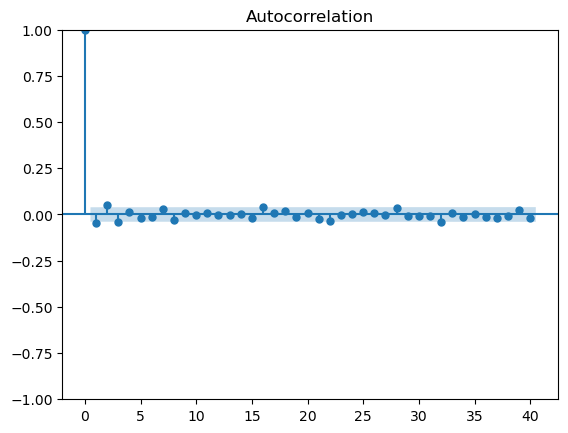

In [8]:
plot_acf(amd_close_log_return, lags=40)

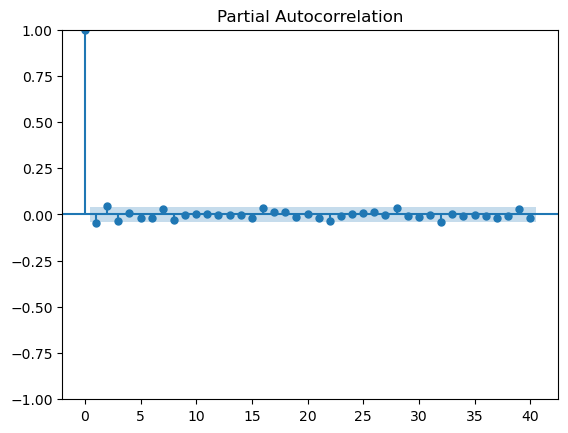

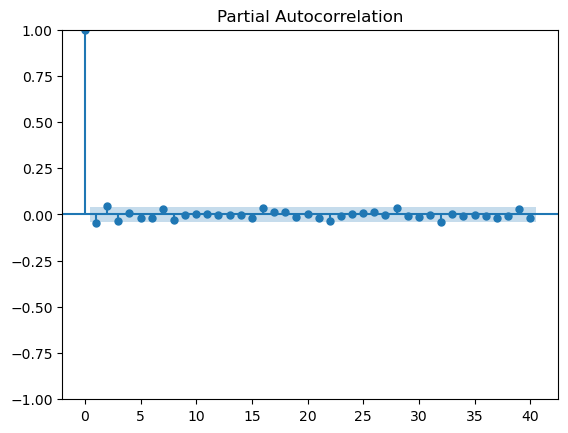

In [9]:
plot_pacf(amd_close_log_return, lags=40)

Note when interpreting ACF and PACF:
1. **ACF tapering slowly:** process not stationary, need differencing.
2. **ACF spike:** MA process on that lag.
3. **PACF spike:** AR process on that lag.

In [40]:
cm_garch_normal = ConstantMean(amd_close_log_return, rescale=True)
cm_garch_normal.volatility = GARCH(p=1, o=0, q=1)
cm_garch_normal.distribution = Normal()
res_garch_normal = cm_garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31633.89677845547
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2828731.483928741
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1194.946496549149
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1183.639974672441
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1066.1217232312606
Iteration:      6,   Func. Count:     42,   Neg. LLF: 963.0712038083872
Iteration:      7,   Func. Count:     48,   Neg. LLF: 959.8988484624829
Iteration:      8,   Func. Count:     54,   Neg. LLF: 959.7908549215463
Iteration:      9,   Func. Count:     59,   Neg. LLF: 959.7908204830412
Iteration:     10,   Func. Count:     63,   Neg. LLF: 959.7908204835189
Optimization terminated successfully    (Exit mode 0)
            Current function value: 959.7908204830412
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


In [41]:
res_garch_normal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -959.791
Distribution:                  Normal   AIC:                           1927.58
Method:            Maximum Likelihood   BIC:                           1950.90
                                        No. Observations:                 2515
Date:                Wed, Sep 18 2024   Df Residuals:                     2514
Time:                        12:32:14   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0178  8.098e-03      2.198  2.794e-02 [1.928e-03,3.367e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0298  1.071e-02      2.782  5.398e-03 [8.808e-03,5.079e-02]
alpha[1]       0.1412  4.480e-02      3.151  1.627e-03   [5.336e-02,  0.229]
beta[1]        0.6439  8.974e-02      7.175  7.220e-13     [  0.468,  0.820]
============================================================================

Covariance estimator: robust
"""

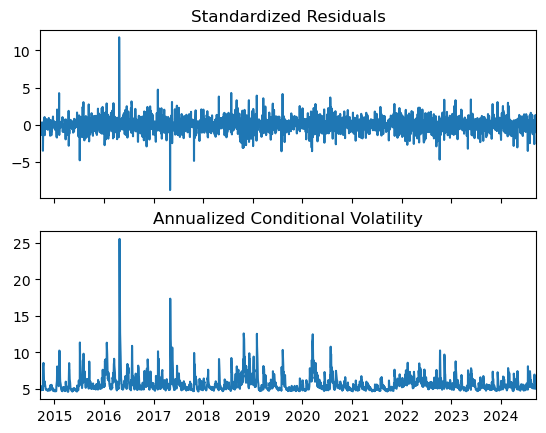

In [42]:
fig_garch_normal = res_garch_normal.plot(annualize="D")

## Model AIC

In [43]:
res_garch_normal.aic

1927.5816409660824

## Model Scaling

In [44]:
res_garch_normal.scale

10.0

## Forecasting Multi-Period Volatility

In [45]:
forecast_30 = res_garch_normal.forecast(horizon=30)
forecast_30

In [46]:
forecast_30.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-17,0.095707,0.104942,0.112192,0.117885,0.122354,0.125862,0.128617,0.13078,0.132478,0.133811,...,0.138342,0.138415,0.138472,0.138517,0.138553,0.138581,0.138602,0.138619,0.138633,0.138643


Rescaling the Variance.

In [47]:
forecast_30_variance_rescaled = forecast_30.variance / np.power(res_gjr_normal.scale, 2)

In [48]:
forecast_30_variance_rescaled

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-17,0.000957,0.001049,0.001122,0.001179,0.001224,0.001259,0.001286,0.001308,0.001325,0.001338,...,0.001383,0.001384,0.001385,0.001385,0.001386,0.001386,0.001386,0.001386,0.001386,0.001386


Convert to Standard Deviation.

In [50]:
forecast_30_stddev = np.sqrt(forecast_30_variance_rescaled)
forecast_30_stddev

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-17,0.030937,0.032395,0.033495,0.034334,0.034979,0.035477,0.035863,0.036164,0.036398,0.03658,...,0.037194,0.037204,0.037212,0.037218,0.037223,0.037226,0.037229,0.037232,0.037233,0.037235


Annualizing Standard Deviation (using 252 day/year daycount).

In [51]:
forecast_30_stddev_annualized = forecast_30_stddev * np.sqrt(252)

In [52]:
forecast_30_stddev_annualized

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-17,0.491103,0.514251,0.531718,0.54504,0.555276,0.563181,0.569311,0.574078,0.577793,0.580693,...,0.590441,0.590598,0.59072,0.590816,0.590892,0.590951,0.590997,0.591034,0.591063,0.591085


Transposing for better array access later on.

In [53]:
forecast_30_stddev_annualized_transposed = pd.melt(forecast_30_stddev_annualized.reset_index(),
                                          id_vars=['Date'], value_vars=forecast_30_stddev_annualized.columns, 
                                            var_name='Day', value_name='Value')

In [54]:
forecast_30_stddev_annualized_array = np.array(forecast_30_stddev_annualized_transposed.Value)

In [55]:
forecast_30_stddev_annualized_array

array([0.49110309, 0.51425062, 0.53171838, 0.54504039, 0.55527575,
       0.56318133, 0.56931119, 0.57407796, 0.57779285, 0.58069281,
       0.5829595 , 0.58473295, 0.58612155, 0.58720946, 0.58806218,
       0.58873079, 0.5892552 , 0.58966659, 0.58998938, 0.59024269,
       0.59044148, 0.59059751, 0.59071998, 0.59081612, 0.59089159,
       0.59095083, 0.59099734, 0.59103385, 0.59106252, 0.59108502])

## GARCH European Call Option Pricer

This model is adapted from Duan 1995 Paper "The GARCH Option Pricing Model".  
  
**TL;DR:** Calibrate the black-scholes SDE's (geometric brownian motion) volatility at every step in the simulation with output from GARCH Model.  
  
**The Long and Winding Explanation:**  
Recall what the black-scholes-merton model basically does:  
it models asset prices as a geometric brownian motion.  
$dS_{t} = \mu S_{t} d_{t} + \sigma S_{t} d W_{t}$  
It assumes that we can do dynamic delta hedging (short or long underlying). Thus in order to be arbitrage-free, we set the drift to the risk free rate $r$.  
$dS_{t} = r S_{t} d_{t} + \sigma S_{t} d W_{t}$  
In order to get option price we simply need to calculate the average value of $S_{T}$ that is below or above strike price $K$ (depends on call or put) where $T$ is time of expiry and multiply it by a continuously-compounding discount factor $e^{-rT}$, Basically finding the present value of expected future cashflow.   
$Call\;Price = e^{-rT}E_{Q}[max(S_{T}-K,0)]$  
$Put\;Price = e^{-rT}E_{Q}[max(K-S_{T},0)]$  
Now the above problems can be solved analytically or via Monte-Carlo Simulations (with Euler-Maruyama Discretization). The numerical solutions is basically this:  
$S_{t_{n+1}} = S_{t_n} \left( 1 + \mu \Delta t + \sigma \sqrt{\Delta t} Z_n \right)$  
where $Z_n \sim N(0,1)$  
The problem with black-scholes is that it assumes that the volatility $\sigma$ is constant, which never holds in real-life markets. Duan aims to correct this by calibrating the $\sigma$ using predictions from GARCH model $\sqrt{h_{t}}$, such that the model becomes:  
$S_{t_{n+1}} = S_{t_n} \left( 1 + \mu \Delta t + \sqrt{h_{t}} \sqrt{\Delta t} Z_n \right)$  
where $Z_n \sim N(0,1)$  

Call Option Price: 3.54


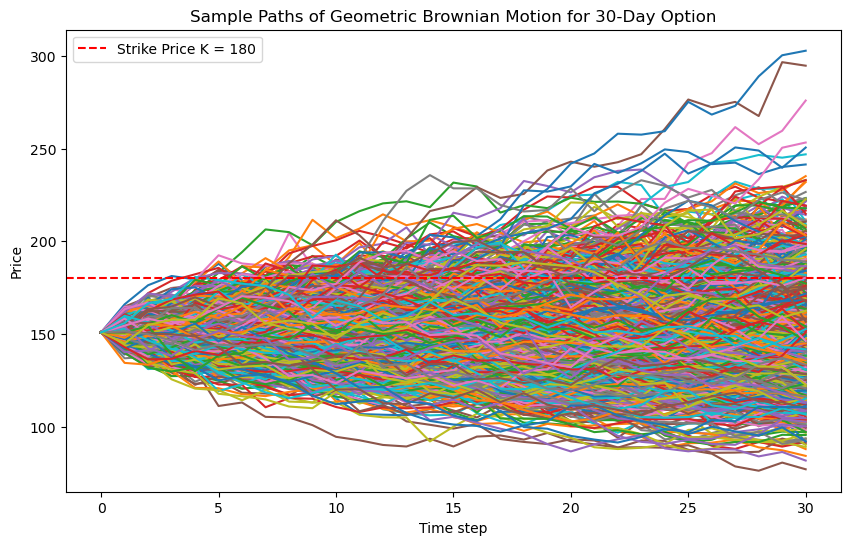

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def GARCH_European_Call_MC(S0, r, sigma_arr, T, n, m, K):
    """
    European Call Pricer MC Pricer using Euler-Maruyama discretization with dynamic sigma

    Parameters:
    - S0: Initial stock price
    - r: Risk-free interest rate
    - sigma_arr: Array of volatilities over time
    - T: Time to maturity
    - n: Number of time steps
    - m: Number of simulation paths
    - K: Strike price

    Returns:
    - call_price: Estimated call option price
    - gbm_paths: Simulated stock price paths
    """
    dt = T / n  
    gbm_paths = np.zeros((m, n + 1))
    gbm_paths[:, 0] = S0  

    for i in range(1, n + 1):
        Z = np.random.standard_normal(m)
        
        gbm_paths[:, i] = gbm_paths[:, i - 1] * (1 + r * dt + sigma_arr[i-1] * np.sqrt(dt) * Z)

    
    payoffs = np.maximum(gbm_paths[:, -1] - K, 0)

    
    discount_factor = np.exp(-r * T)
    call_price = discount_factor * np.mean(payoffs)
    
    return call_price, gbm_paths


S0 = 150.82 
K = 180  
r = 0.055
sigma_arr = forecast_30_stddev_annualized_array
# sigma_arr = np.full(30, 0.5) 
T = 30 / 252  # Time horizon (30 days out of 252)
n = 30  # Number of time steps (if 30 means daily steps)
m = 1000000

call_price, gbm_paths = GARCH_European_Call_MC(S0, r, sigma_arr, T, n, m, K)

print(f"Call Option Price: {call_price:.2f}")


plt.figure(figsize=(10, 6))
plt.plot(gbm_paths[:1000].T)  
plt.axhline(y=K, color='r', linestyle='--', label=f'Strike Price K = {K}') 
plt.title("Sample Paths of Geometric Brownian Motion for 30-Day Option")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.legend()
plt.show()

For comparison, here is a vanilla black scholes fitted with the approximate 30-day historical volatility.  
Note: Find out how Black-Scholes closed form is derived

$d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left( r + \frac{\sigma^2}{2} \right) T}{\sigma \sqrt{T}}$  

$d_2 = d_1 - \sigma \sqrt{T}$  

$C = S_0 \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$  

In [67]:
import numpy as np
from scipy.stats import norm

def black_scholes_call_price(S0, K, r, T, sigma):
    """
    European Call Option Black-Scholes Analytic Pricer
    
    Parameters:
    - S0: Current stock price
    - K: Strike price
    - r: Risk-free interest rate
    - T: Time to maturity (in years)
    - sigma: Volatility of the underlying asset
    
    Returns:
    - call_price: The price of the call option
    """
    
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price


S0 = 150.82 
K = 180  
r = 0.055  
T = 30 / 252     # Time to maturity (30 day)
sigma = 0.48 

call_option_price = black_scholes_call_price(S0, K, r, T, sigma)
print(f"The Black-Scholes call option price is: {call_option_price:.2f}")

The Black-Scholes call option price is: 2.14
